# 03_BASELINES
**Date:** 06-10-2025

**Goals:** put the first baseline classifier and captioner models to work. Later, add multimodal fusion and compare results.

In [6]:
# imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
from data_loader import load_data

labels_and_paths_csv_fp_PC_sample = r"C:\Users\user\PycharmProjects\galaxy_morphology_ml_captioning\data\labels\labels_manifest_1000.csv" # sample labels filepath (PC)
labels_and_paths_csv_fp_laptop_sample = r"C:\Users\79263\galaxy_morphology_ml_captioning\data\labels\labels_manifest_1000.csv" # sample labels filepath (laptop)
labels_and_paths_csv_fp_PC_full = r"C:\Users\user\PycharmProjects\galaxy_morphology_ml_captioning\data\processed\manifest_train_and_val.csv" # full labels filepath (PC)
labels_and_paths_csv_fp_laptop_full = r"C:\Users\79263\galaxy_morphology_ml_captioning\data\processed\manifest_train_and_val.csv" # full labels filepath (laptop)
full_dataset_present = False

np.random.seed(5629) # random seed for reproducibility
tf.random.set_seed(5629)

Let's start with the classifier. For it, I am using a simple CNN sequential model from tensorflow.keras with a pretrained (ResNet50) head.

In [7]:
baseline_CNN_model = tf.keras.models.Sequential([ # baseline CNN model (input -> resnet50 -> convolution and max pooling layers -> dense layers with relu and softmax
    layers.InputLayer(input_shape=(224,224,3)),

    layers.RandomFlip(),
    layers.RandomRotation(1),
    layers.RandomTranslation(0.2, 0.2),

    tf.keras.applications.ResNet50(include_top=False,),

    layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    layers.Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(5 if full_dataset_present else 4, activation='softmax')
])

C:\Users\user\PycharmProjects\galaxy_morphology_ml_captioning\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


## Breakdown of the model:
- an input layer that takes the images' preprocessed data
- data augmentation layers (it is safe to use rotation and translation, as the position of the galaxy doesn't matter for classification, but crop, color change, etc. can skew the images)
- ResNet50 pre-trained head, made not trainable for our purposes
- multiple convolution + max pooling layers
- flatten the input to the dense layers
- finally, a few dense layers with relu activation + final layer: 5* output nodes (5 categories of galaxies), softmax activation.

_*only 4 categories in the sample (ambiguous not represented)._

Now, let's compile the model with categorical crossentropy loss to evaluate error among categories:

In [8]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.001) # Adam optimizer as a superior for this task

baseline_CNN_model.compile( # compilation
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

It is time to load the data using data_loader.py and fit the model!

In [ ]:
train_sample, valid_sample = load_data(labels_and_paths_csv_fp_PC_sample, "PC") # data loading (see data_loader.py)

history = baseline_CNN_model.fit( # fitting
    train_sample,
    validation_data=valid_sample,
    epochs=50
)

After a long time, the model finished fitting. To evaluate the results of the classifier, let's plot loss and accuracy graphs:

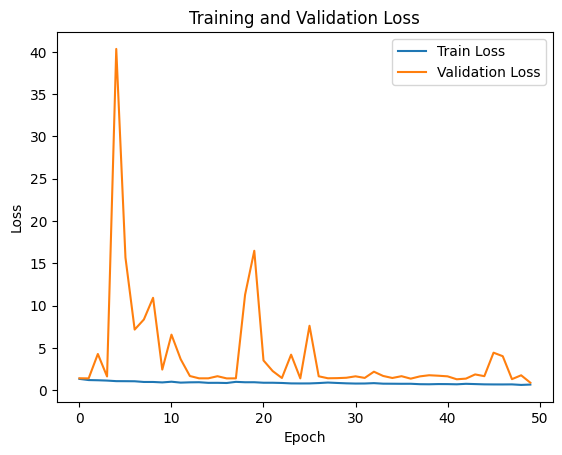

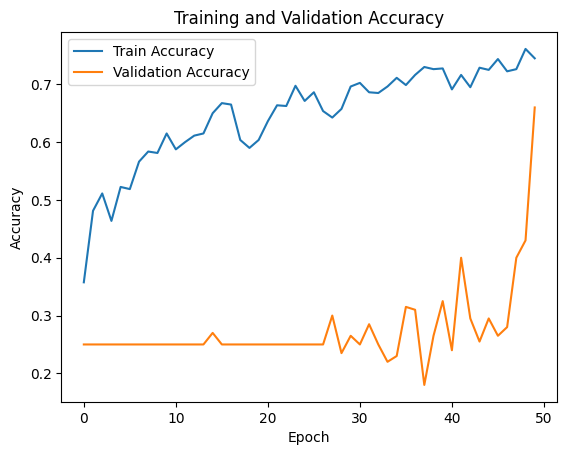

In [10]:
hist = history.history

# plotting time!
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

As can be seen, the training data accuracy shows steady growth. However, the validation curve is unstable and spiky near the end.

This means that the model is either overfitting or incorrectly interpreting the data with the pretrained head. Also, the augmentation may be too violent.

I softened the augmentation parameters and also froze the head to avoid overfitting + deleted convolution layers to reduce the amount of parameters and clutter overall.
The model really improved, and here are the new plots:

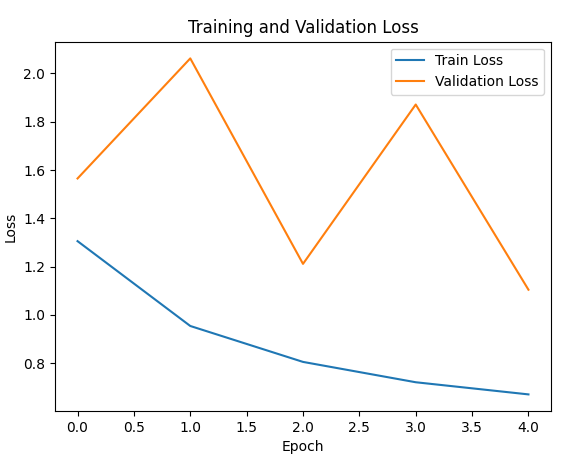

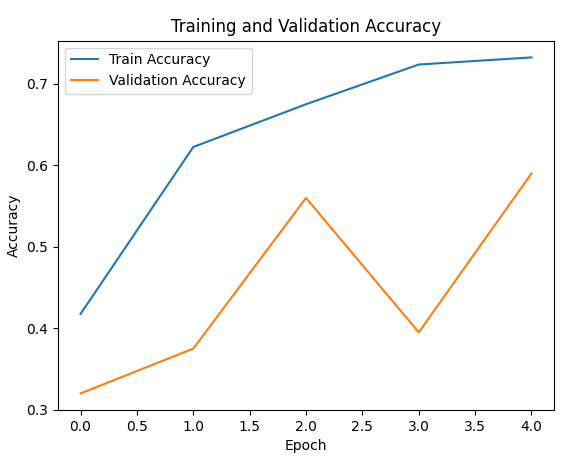